# 4.7.5 라쏘(Lasso) 모델(계속)

# 데이터 스케일 조정 없는 house-unscaled로 Lasso 실행

In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv('house-unscaled.csv')   
df.shape

(20495, 93)

In [7]:
data = df.drop(['VALP_B1'], axis=1)   # 타겟변수를 제외한 입력변수를 data에 저장
target = df['VALP_B1']                # 타겟변수만 target에 저장

# 50:50 데이터 분할
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( 
    data, target, test_size=0.5, random_state=42)   # test_size=0.5임에 주의 

print("X_train shape:", X_train.shape) 
print("X_test shape:", X_test.shape) 

X_train shape: (10247, 92)
X_test shape: (10248, 92)


In [8]:
# Lasso 모델 (Default 모델 for liblinear)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
ls = LogisticRegression(penalty='l1',solver='liblinear',C=1,random_state=0)
model = ls.fit(X_train, y_train) 
pred = model.predict(X_test)  # 학습된 Classifier로 테스트 데이터셋 자료이용해서 타겟변수 예측값 생성

print ("Lasso Accuracy on training set:{:.5f}".format(model.score(X_train, y_train))) 
print ("Lasso Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Lasso Accuracy on training set:0.74851
Lasso Accuracy on test set:0.72834


In [9]:
# Lasso 모델 (Default 모델 for liblinear)
ls = LogisticRegression(penalty='l1',solver='liblinear',C=1,random_state=0)

In [10]:
# 그리드 서치 실행
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold  

# StratifiedKFold의 random_state 옵션값을 특정 숫자(예: 0)로 고정
cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
params = {'solver':['lbfgs', 'liblinear', 'sag', 'saga'],
          'C':[0.01,0.05,0.1,0.2,0.3,0.5,1]
         }

# GridSearchCV의 cv=cross_validation 옵션값은 위의 StratifiedKFold의 random_state 옵션값을 적용시켜서
# GridSearchCV를 실행핼 때마다 결과가 항상 동일하게 나오도록 보장
grid_ls = GridSearchCV(ls, param_grid=params, scoring='accuracy', cv=cross_validation,
                       n_jobs=-1, verbose=1)
grid_ls.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_ls.best_score_))
print("GridSearchCV best parameter:", (grid_ls.best_params_))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.70381421        nan 0.49702341        nan 0.73201814
        nan 0.49702341        nan 0.73787342        nan 0.49702341
        nan 0.74138714        nan 0.49702341        nan 0.74148508
        nan 0.49702341        nan 0.7439251         nan 0.49702341
        nan 0.74324189        nan 0.49702341]
  warnings.warn(


GridSearchCV max accuracy:0.74393
GridSearchCV best parameter: {'C': 0.5, 'solver': 'liblinear'}


In [14]:
best_clf = grid_ls.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test,best_clf.predict_proba(X_test)[:, 1])
print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

Accuracy on test set:0.72990
ROC AUC on test set:0.80693


In [15]:
print ("Number of features used:", np.sum(best_clf.coef_ != 0))

Number of features used: 77


In [39]:
print('회귀계수', best_clf.coef_)

회귀계수 [[ 9.00214324e-03 -8.68577500e-01  4.68134681e-01  1.02840101e-03
   0.00000000e+00  2.74208859e-01 -2.77789447e-02  8.55782608e-02
   1.78056039e-03  1.34917916e-05  1.52629424e-02 -5.65390826e-01
   1.94511777e-01 -8.25125340e-01  4.16586945e-01  0.00000000e+00
  -1.41641066e+00 -5.87059439e-01 -1.01505908e+00  9.05169698e-02
  -2.10223804e-01 -8.97644806e-02 -2.31231626e-01 -2.25303665e-01
  -3.33821743e-01 -3.44275627e-02  4.41448206e-01 -2.19643951e-01
  -8.57552494e-01  3.00233609e-01  2.62387013e-01 -7.44827018e-03
  -1.01776527e-01 -6.51868324e-01  0.00000000e+00  4.73209479e-01
  -6.56798340e-01 -1.14055838e+00 -8.33780899e-01 -5.57358158e-02
   0.00000000e+00  4.63897598e-01  5.25465169e-01  5.22827887e-02
   0.00000000e+00 -1.72402821e-01 -1.26034928e-01  0.00000000e+00
   8.71250220e-01  1.53397758e+00  1.11696862e+00  1.01100953e+00
   6.95927594e-01  1.58912581e-01  1.20688810e-01  2.06480111e-01
   2.26918365e-01  0.00000000e+00 -1.18783191e-01  0.00000000e+00
   0.

In [40]:
# 변수명을 Index로 만들고 coefficient값을 매칭한 데이터프레임 만들기 

feature_names = list(data.columns)   # 변수명(컬럼명)을 리스트 형태로 만들기
dft = pd.DataFrame(best_clf.coef_.transpose(), index=feature_names,
                   columns=['coef'])
dft1 = dft.sort_values(by='coef', ascending=False)   # 컬럼 coef의 값들을 내림차순으로 정리
dft1 

,coef
MV_2.0,1.533978
MV_3.0,1.116969
MV_4.0,1.011010
MV_1.0,0.871250
SCH_3,0.826206
...,...
FPARC_0,-0.857552
BATH,-0.868577
BLD_2.0,-1.015059
HHT_2.0,-1.140558


In [41]:
# Odds ratio 계산

feature_names = list(data.columns)   # 변수명(컬럼명)을 리스트 형태로 만들기
dft = pd.DataFrame(np.exp(best_clf.coef_).transpose(), index=feature_names,
                   columns=['Odds_ratio'])
dft1 = dft.sort_values(by='Odds_ratio', ascending=False)   # 컬럼 coef의 값들을 내림차순으로 정리
dft1  

,Odds_ratio
MV_2.0,4.636583
MV_3.0,3.055578
MV_4.0,2.748374
MV_1.0,2.389897
SCH_3,2.284635
...,...
FPARC_0,0.424199
BATH,0.419548
BLD_2.0,0.362381
HHT_2.0,0.319640


In [42]:
# Odds ratio가 1(즉, 원 계수값이 0)인 변수들을 제거
dft2 = dft1[dft1['Odds_ratio']!= 1]
dft2.shape

(77, 1)

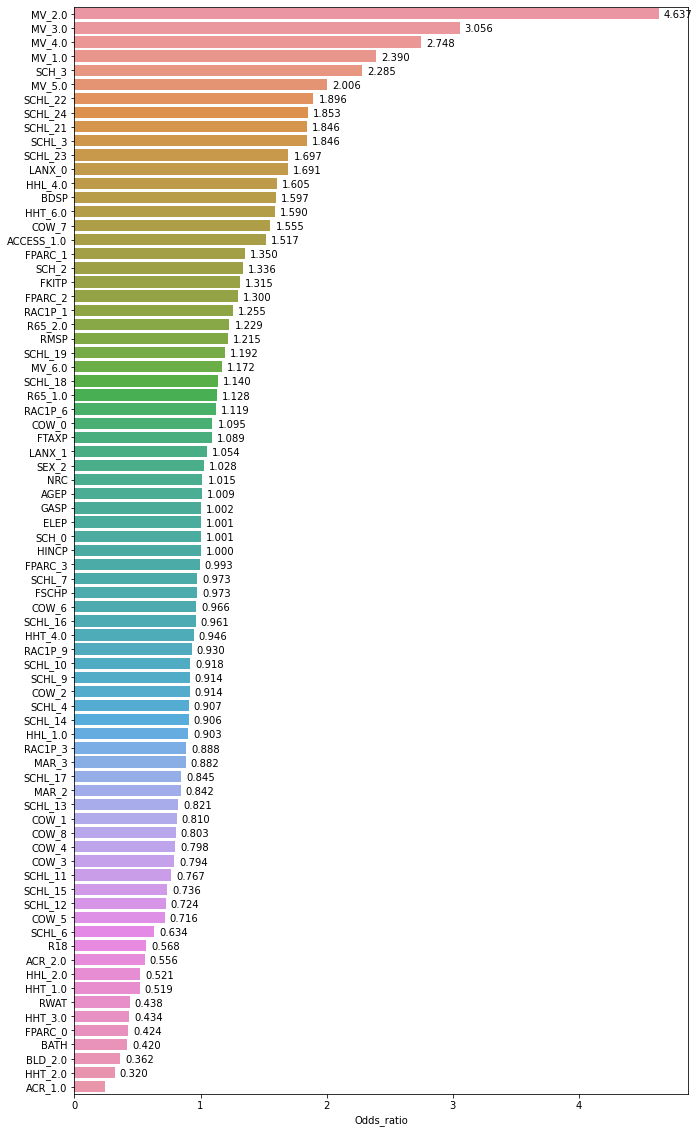

In [49]:
# 데이터프레임 dft2의 막대그래프 그리기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(11, 20))
ax = sns.barplot(y=dft2.index, x="Odds_ratio", data=dft2)

for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()+1.4),
                xytext=(5, 10), textcoords='offset points')

In [16]:
# maxiter=1,000으로 설정. 이를 초과하면 singular matrix 에러 발생

import statsmodels.api as sm 
log_reg = sm.Logit(y_train, X_train).fit(maxiter=1000)

         Current function value: 0.517257
         Iterations: 1000


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
print(log_reg.summary()) 

                           Logit Regression Results                           
Dep. Variable:                VALP_B1   No. Observations:                10247
Model:                          Logit   Df Residuals:                    10156
Method:                           MLE   Df Model:                           90
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                  0.2535
Time:                        16:26:54   Log-Likelihood:                -5300.3
converged:                      False   LL-Null:                       -7099.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AGEP           0.0122      0.003      4.258      0.000       0.007       0.018
BATH           0.6334      0.747      0.848      0.396      -0.830       2.097
BDSP           0.5052      0.043     11.771      0.0

# 로그 변환한 데이터로 Lasso 실행

In [11]:
import pandas as pd
import numpy as np
df = pd.read_csv('house-log.csv')   
df.shape

(20495, 93)

In [12]:
data = df.drop(['VALP_B1'], axis=1)   # 타겟변수를 제외한 입력변수를 data에 저장
target = df['VALP_B1']                # 타겟변수만 target에 저장

# 50:50 데이터 분할
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( 
    data, target, test_size=0.5, random_state=42)   # test_size=0.5임에 주의 

print("X_train shape:", X_train.shape) 
print("X_test shape:", X_test.shape) 

X_train shape: (10247, 92)
X_test shape: (10248, 92)


In [13]:
# Lasso 모델 (Default 모델 for liblinear)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
ls = LogisticRegression(penalty='l1',solver='liblinear',C=1,random_state=0)
model = ls.fit(X_train, y_train) 
pred = model.predict(X_test)  # 학습된 Classifier로 테스트 데이터셋 자료이용해서 타겟변수 예측값 생성
accuracy = accuracy_score(y_test, pred)

print ("Lasso Accuracy on training set:{:.5f}".format(model.score(X_train, y_train))) 
print ("Lasso Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Lasso Accuracy on training set:0.74666
Lasso Accuracy on test set:0.72541


In [14]:
# Lasso 모델 (Default 모델 for liblinear)
ls = LogisticRegression(penalty='l1',solver='liblinear',C=1,random_state=0)

In [15]:
# 그리드 서치 실행
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold  

# StratifiedKFold의 random_state 옵션값을 특정 숫자(예: 0)로 고정
cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
params = {'solver':['lbfgs', 'liblinear', 'sag', 'saga'],
          'C':[0.01,0.05,0.1,0.2,0.3,0.5,1]
         }

# GridSearchCV의 cv=cross_validation 옵션값은 위의 StratifiedKFold의 random_state 옵션값을 적용시켜서
# GridSearchCV를 실행핼 때마다 결과가 항상 동일하게 나오도록 보장
grid_ls = GridSearchCV(ls, param_grid=params, scoring='accuracy', cv=cross_validation,
                       n_jobs=-1, verbose=1)
grid_ls.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_ls.best_score_))
print("GridSearchCV best parameter:", (grid_ls.best_params_)) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.67512381        nan 0.71269507        nan 0.72440662
        nan 0.72831011        nan 0.73670297        nan 0.73621517
        nan 0.73933859        nan 0.73885041        nan 0.74011913
        nan 0.74002205        nan 0.7398263         nan 0.73816715
        nan 0.74011908        nan 0.73904572]
  warnings.warn(


GridSearchCV max accuracy:0.74012
GridSearchCV best parameter: {'C': 0.3, 'solver': 'liblinear'}


In [16]:
best_clf = grid_ls.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test,best_clf.predict_proba(X_test)[:, 1])
print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

Accuracy on test set:0.72590
ROC AUC on test set:0.79936


# StandardScaler로 표준화한 데이터로 Lasso 실행

In [31]:
import pandas as pd
import numpy as np
df = pd.read_csv('house-standard.csv')   
df.shape

(20495, 93)

In [32]:
data = df.drop(['VALP_B1'], axis=1)   # 타겟변수를 제외한 변수만 data에 저장
target = df['VALP_B1']                # 타겟변수만 target에 저장

# 50:50 데이터 변환
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( 
    data, target, test_size=0.5, random_state=42)   # test_size=0.5임에 주의 

print("X_train shape:", X_train.shape) 
print("X_test shape:", X_test.shape) 

X_train shape: (10247, 92)
X_test shape: (10248, 92)


In [33]:
# Lasso 모델 (Default 모델 for liblinear)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
ls = LogisticRegression(penalty='l1',solver='liblinear',C=1,random_state=0)
model = ls.fit(X_train, y_train) 
pred = model.predict(X_test)  # 학습된 Classifier로 테스트 데이터셋 자료이용해서 타겟변수 예측값 생성
accuracy = accuracy_score(y_test, pred)

print ("Lasso Accuracy on training set:{:.5f}".format(model.score(X_train, y_train))) 
print ("Lasso Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Lasso Accuracy on training set:0.74851
Lasso Accuracy on test set:0.72843


In [34]:
# Lasso 모델 (Default 모델 for liblinear)
ls = LogisticRegression(penalty='l1',solver='liblinear',C=1,random_state=0)

In [35]:
# 그리드 서치 실행
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold  

# StratifiedKFold의 random_state 옵션값을 특정 숫자(예: 0)로 고정
cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
params = {'solver':['lbfgs','liblinear','sag','saga'],
                    'C':[0.01,0.05,0.1,0.2,0.3,0.5,1]
                    }

# GridSearchCV의 cv=cross_validation 옵션값은 위의 StratifiedKFold의 random_state 옵션값을 적용시켜서
# GridSearchCV를 실행핼 때마다 결과가 항상 동일하게 나오도록 보장
grid_ls = GridSearchCV(ls, param_grid=params, scoring='accuracy', cv=cross_validation,\
                       n_jobs=-1,\
                       verbose=1)
grid_ls.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_ls.best_score_))
print("GridSearchCV best parameter:", (grid_ls.best_params_)) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.71103587        nan 0.7073275         nan 0.73211589
        nan 0.73270135        nan 0.73826457        nan 0.73894759
        nan 0.74246031        nan 0.7423627         nan 0.7427538
        nan 0.7432418         nan 0.74343725        nan 0.74314443
        nan 0.7433395         nan 0.74314428]
  warnings.warn(


GridSearchCV max accuracy:0.74344
GridSearchCV best parameter: {'C': 0.5, 'solver': 'liblinear'}


In [36]:
best_clf = grid_ls.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test,best_clf.predict_proba(X_test)[:, 1])
print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

Accuracy on test set:0.72931
ROC AUC on test set:0.80707
